In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle
from glob import glob

"""Change to the data folder"""
new_path = "./new_train/new_train/"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=new_path)

### Create a loader to enable batch processing

In [3]:
batch_sz = 64

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    track_ids = [scene['track_id'] for scene in batch]
    agent_ids = [scene['agent_id'] for scene in batch]
    car_mask = [scene['car_mask'] for scene in batch]
    inp = torch.LongTensor(inp)
    out = torch.LongTensor(out)
    car_mask = torch.LongTensor(car_mask)
    return [inp, out, track_ids, agent_ids, car_mask]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)

### Visualize the batch of sequences

In [ ]:
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

scene_num = 1

for i_batch, sample_batch in enumerate(tqdm(val_loader)):
    inp, out, track_ids, agent_ids, car_mask = sample_batch
    num_tracked = 0
    for i in range(car_mask.shape[1]):
        if car_mask[scene_num][i][0] == 1:
            num_tracked += 1
        else:
            break
    
    print(num_tracked)
    first_scene = inp[scene_num]
    for i in range(num_tracked):
        car = first_scene[i]
        x = []
        y = []
        for j in range(19):
            x.append(car[j][0].item())
            y.append(car[j][1].item())
        plt.plot(x,y)
    plt.show()
    
    first_scene = out[scene_num]
    for i in range(num_tracked):
        car = first_scene[i]
        x = []
        y = []
        for j in range(30):
            x.append(car[j][0].item())
            y.append(car[j][1].item())
        plt.plot(x,y)
    plt.show()
    
    break

In [ ]:
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

x_in = []
y_in = []
x_out = []
y_out = []
vel_x_in = []
vel_x_out = []
vel_y_in = []
vel_y_out = []

for i_batch, sample_batch in enumerate(tqdm(val_loader)):
    inp, out, track_ids, agent_ids, car_mask = sample_batch
    
    if i_batch >= 51485:
        continue
    
    for i in range(batch_sz):
        scene = inp[i]
        
        for j in range(scene.shape[0]):
            if car_mask[i][j][0] == 1:
                x_in.extend([x.item() for x in inp[i,j,:,0]])
                y_in.extend([y.item() for y in inp[i,j,:,1]])
                x_out.extend([x.item() for x in out[i,j,:,0]])
                y_out.extend([y.item() for y in out[i,j,:,1]])
                vel_x_in.extend([x.item() for x in inp[i,j,:,2]])
                vel_y_in.extend([y.item() for y in inp[i,j,:,3]])
                vel_x_out.extend([x.item() for x in out[i,j,:,2]])
                vel_y_out.extend([y.item() for y in out[i,j,:,3]])
            else:
                break
    

    #show_sample_batch(sample_batch, agent_id)

In [4]:
import json

x_in = []
y_in = []
vel_x_in = []
vel_y_in = []

with open('x_in.txt', 'r') as filehandle:
    x_in = json.load(filehandle)

with open('y_in.txt', 'r') as filehandle:
    y_in = json.load(filehandle)
    
with open('vel_x_in.txt', 'r') as filehandle:
    vel_x_in = json.load(filehandle)
    
with open('vel_y_in.txt', 'r') as filehandle:
    vel_y_in = json.load(filehandle)

In [11]:
print('x_in: ' + str(np.mean(x_in)))
print('y_in: ' + str(np.mean(y_in)))
print('vel_x_in: ' + str(np.mean(vel_x_in)))
print('vel_y_in: ' + str(np.mean(vel_y_in)))

1474.6499039101423
2175.5066745340428
0.1489193408934845
-0.16994685542095994


In [6]:
print('x_in: ' + str(np.std(x_in)))
print('y_in: ' + str(np.std(y_in)))
print('vel_x_in: ' + str(np.std(vel_x_in)))
print('vel_y_in: ' + str(np.std(vel_y_in)))

x_in: 1283.2869100687803
y_in: 868.4994220908388
vel_x_in: 4.313724916476951
vel_y_in: 5.3678594328349645


In [5]:
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

vel_x_target_in = []
vel_x_target_out = []
vel_y_target_in = []
vel_y_target_out = []

for i_batch, sample_batch in enumerate(tqdm(val_loader)):
    inp, out, track_ids, agent_ids, car_mask = sample_batch
    
    for i in range(inp.shape[0]):
        scene = inp[i]
        agent_id = agent_ids[i]
        
        vehicle_index = 0
        found = False
        while not found:
            if track_ids[i][vehicle_index][0][0] == agent_id:
                found = True
            else:
                vehicle_index += 1
        
        vel_x_target_in.extend([x.item() for x in inp[i,vehicle_index,:,2]])
        vel_y_target_in.extend([y.item() for y in inp[i,vehicle_index,:,3]])
        vel_x_target_out.extend([x.item() for x in out[i,vehicle_index,:,2]])
        vel_y_target_out.extend([y.item() for y in out[i,vehicle_index,:,3]])

In [7]:
import json
    
with open('vel_x_target_in.txt', 'w') as filehandle:
    json.dump(vel_x_target_in, filehandle)
    
with open('vel_x_target_out.txt', 'w') as filehandle:
    json.dump(vel_x_target_out, filehandle)

with open('vel_y_target_in.txt', 'w') as filehandle:
    json.dump(vel_y_target_in, filehandle)

with open('vel_y_target_out.txt', 'w') as filehandle:
    json.dump(vel_y_target_out, filehandle)

In [22]:
print(min(vel_y_target_out))
print(max(vel_y_target_out))

-79
78


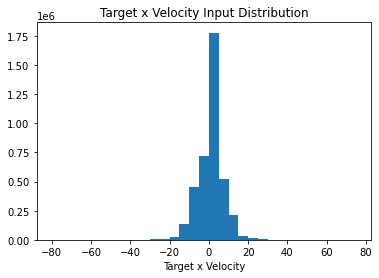

In [15]:
import matplotlib.pyplot as plt

bins=[]
for i in range(-80,80,5):
    bins.append(i)

n, bins, patches = plt.hist(x=vel_x_target_in, bins=bins, density=False)
plt.xlabel('Target x Velocity') 
plt.title('Target x Velocity Input Distribution')
plt.show()

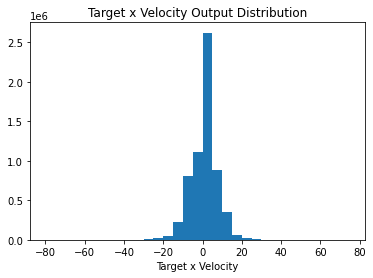

In [19]:
import matplotlib.pyplot as plt

bins=[]
for i in range(-80,80,5):
    bins.append(i)

n, bins, patches = plt.hist(x=vel_x_target_out, bins=bins, density=False)
plt.xlabel('Target x Velocity') 
plt.title('Target x Velocity Output Distribution')
plt.show()

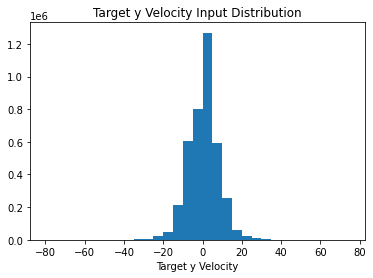

In [21]:
import matplotlib.pyplot as plt

bins=[]
for i in range(-80,80,5):
    bins.append(i)

n, bins, patches = plt.hist(x=vel_y_target_in, bins=bins, density=False)
plt.xlabel('Target y Velocity') 
plt.title('Target y Velocity Input Distribution')
plt.show()

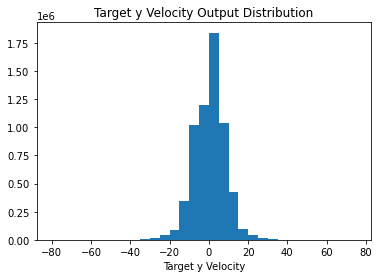

In [23]:
import matplotlib.pyplot as plt

bins=[]
for i in range(-80,80,5):
    bins.append(i)

n, bins, patches = plt.hist(x=vel_y_target_out, bins=bins, density=False)
plt.xlabel('Target y Velocity') 
plt.title('Target y Velocity Output Distribution')
plt.show()

In [4]:
model = torch.load('./models/12InitialWorkspace.pt')
cuda_status = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)
if cuda_status:
    model = model.cuda()

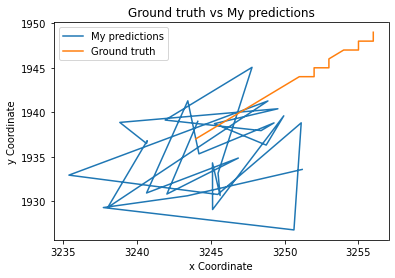

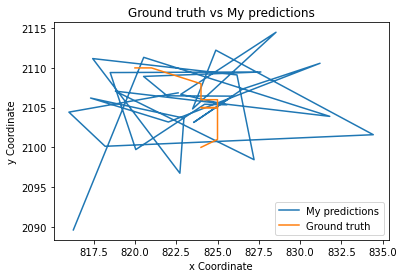

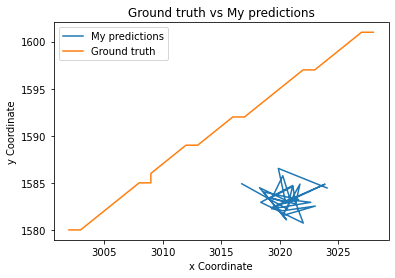

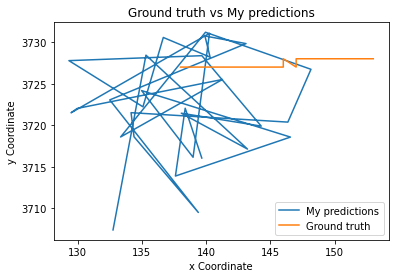

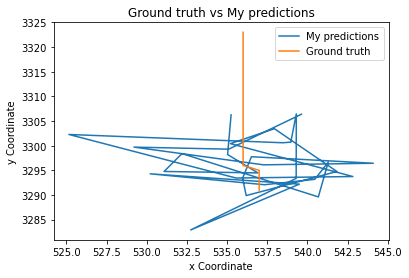

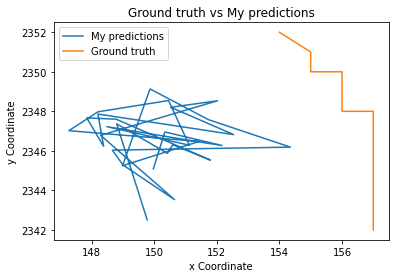

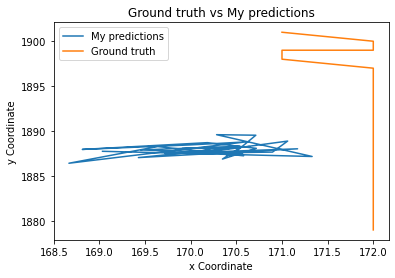

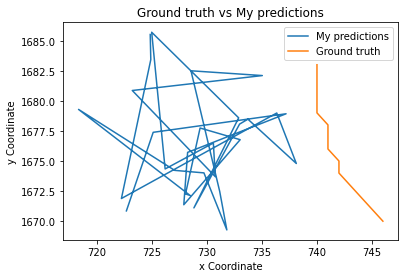

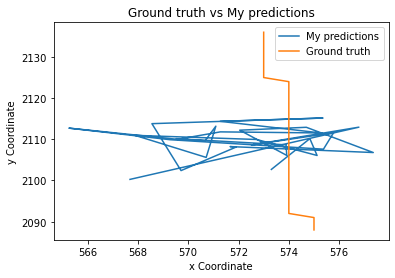

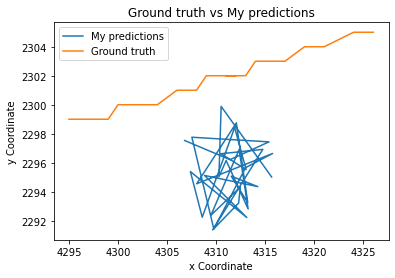

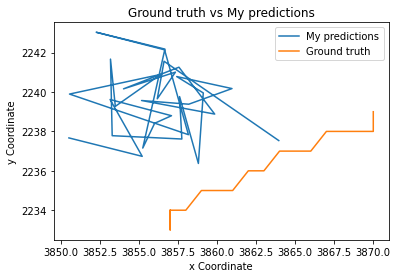

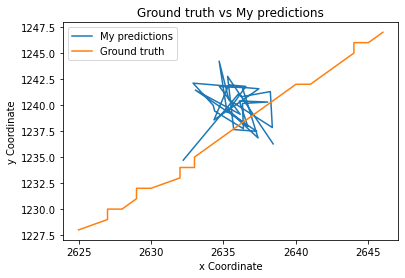

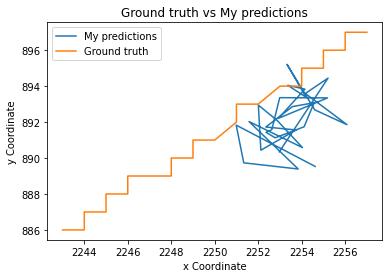

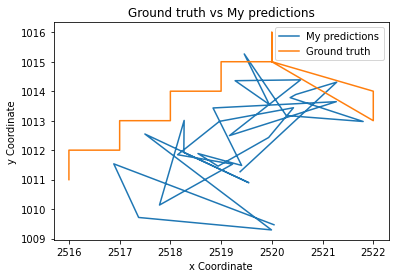

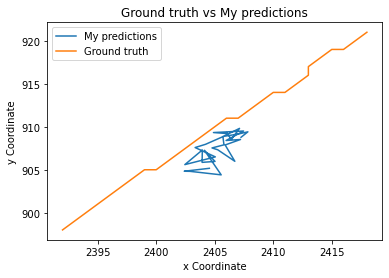

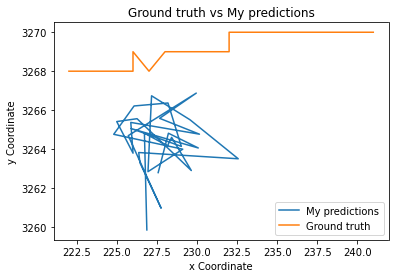

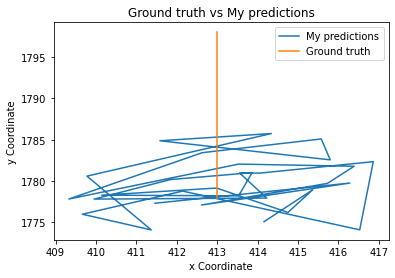

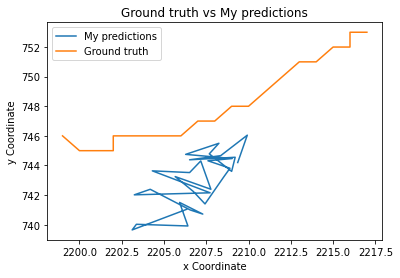

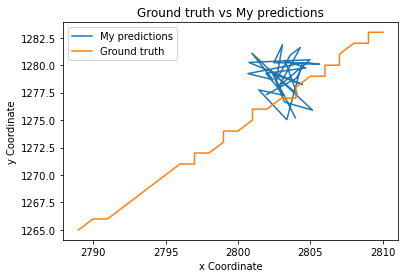

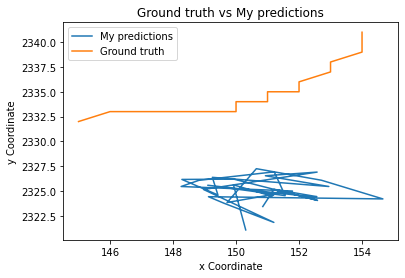

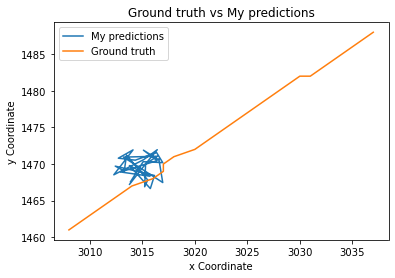

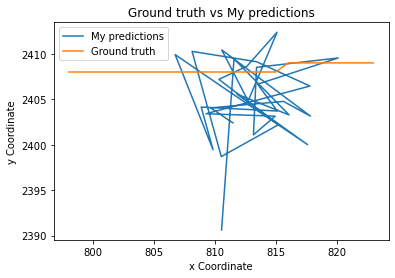

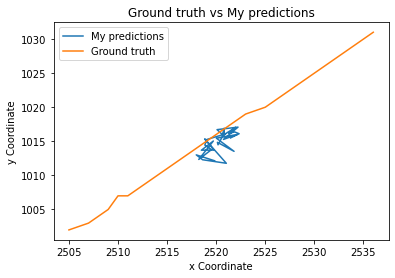

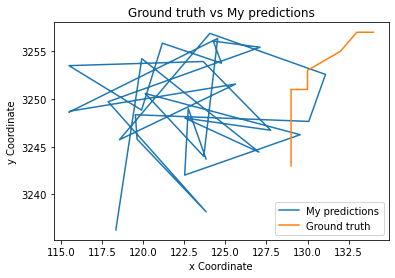

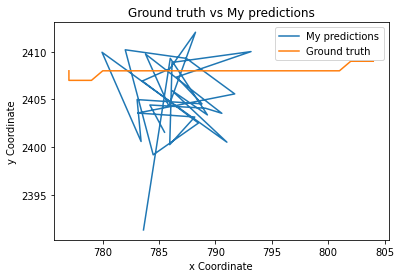

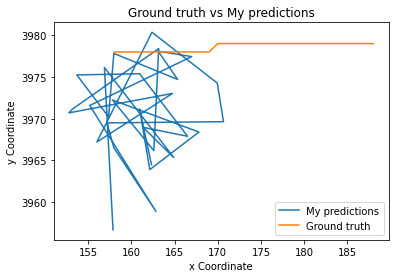

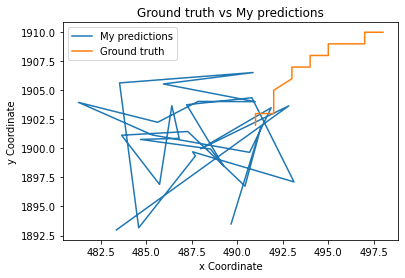

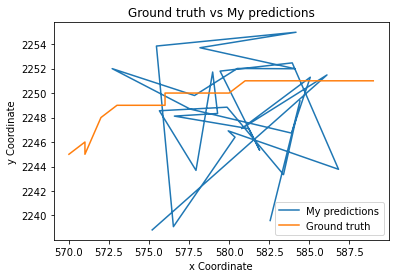

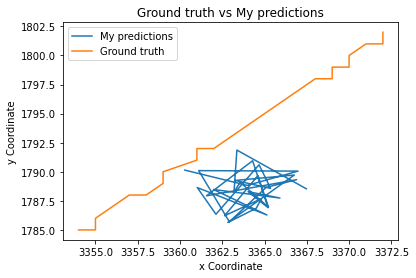

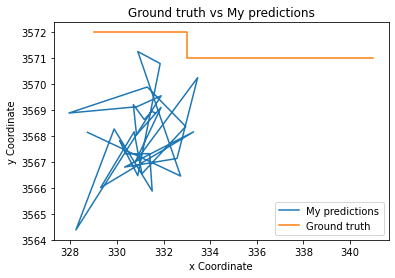

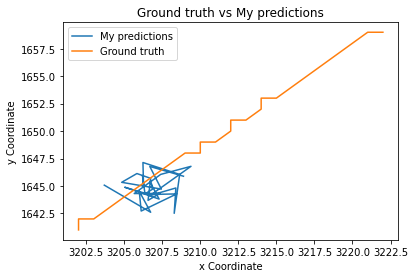

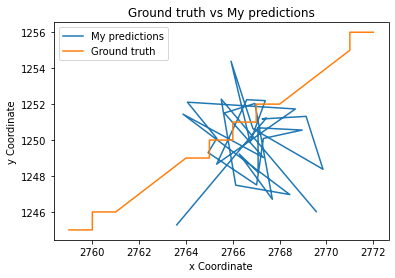

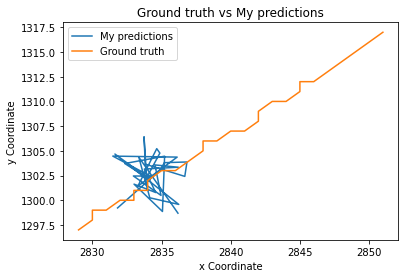

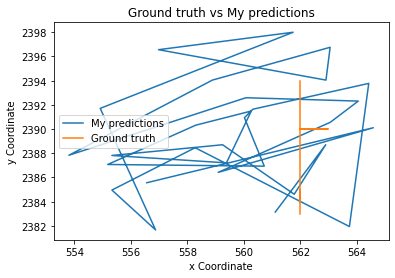

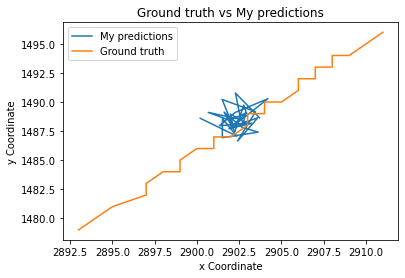

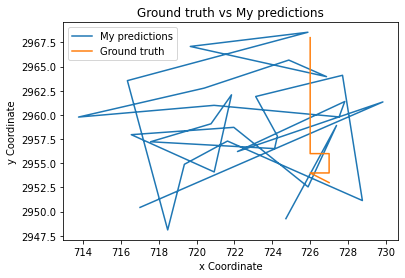

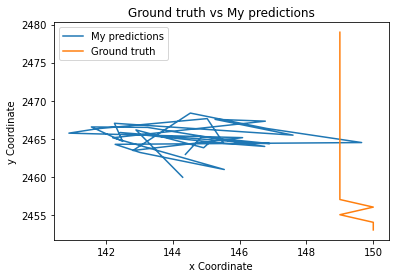

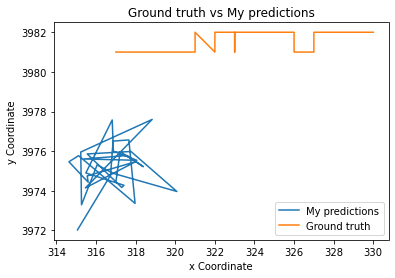

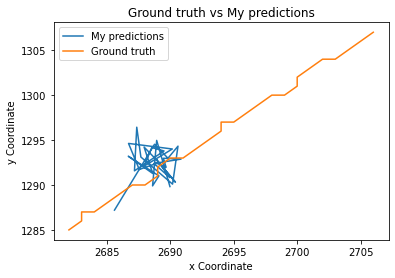

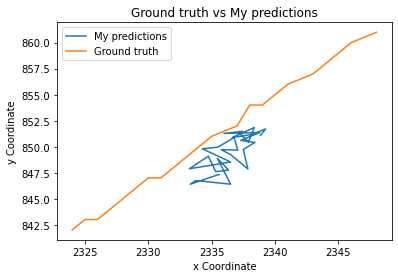

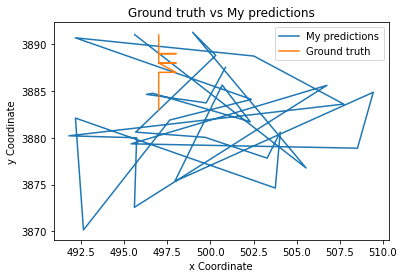

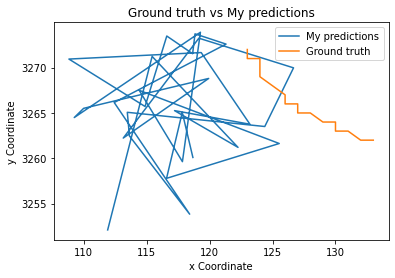

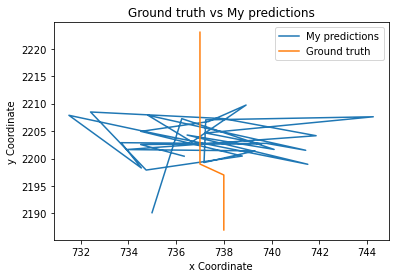

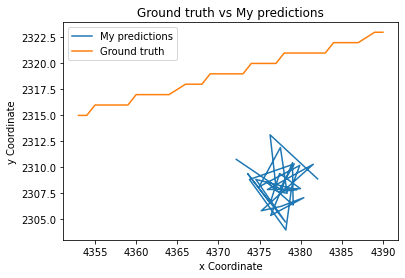

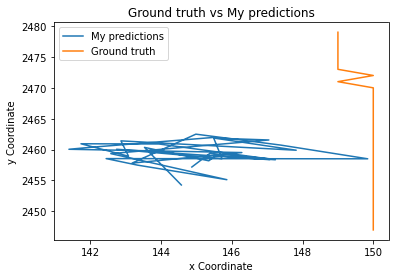

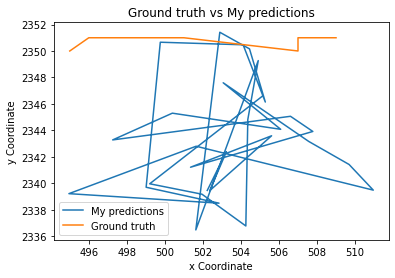

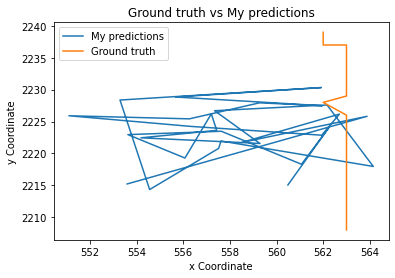

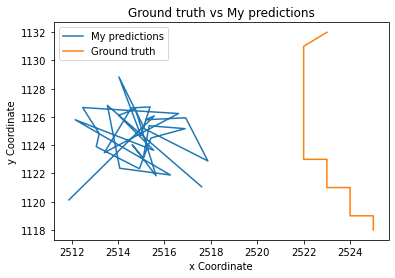

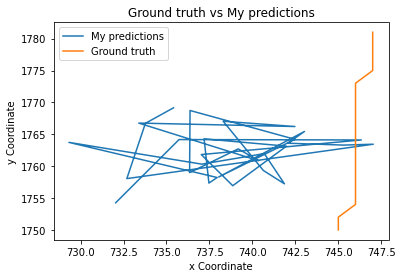

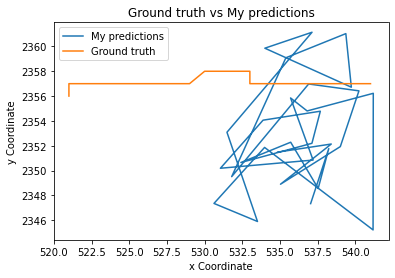

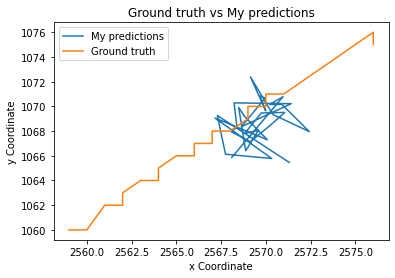

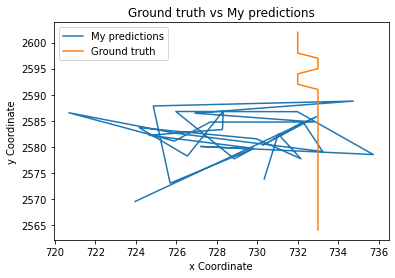

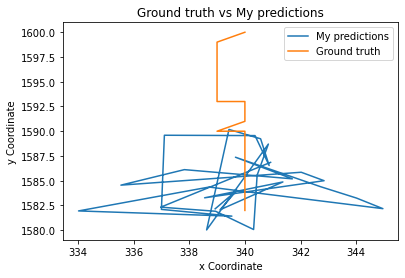

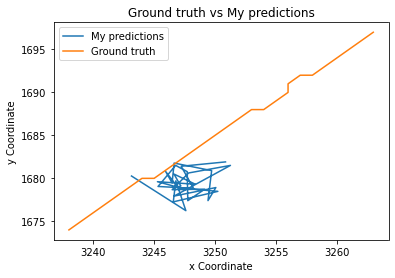

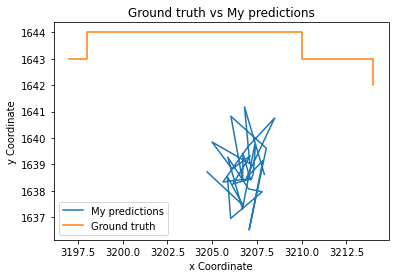

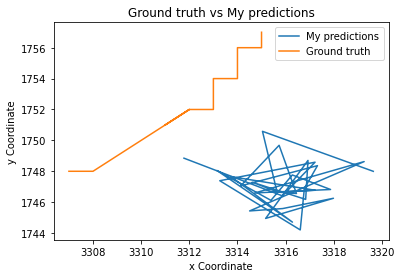

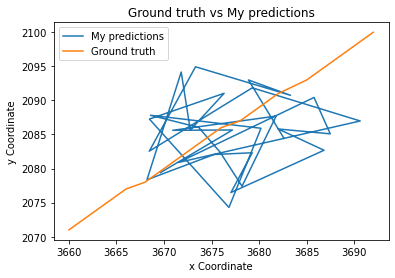

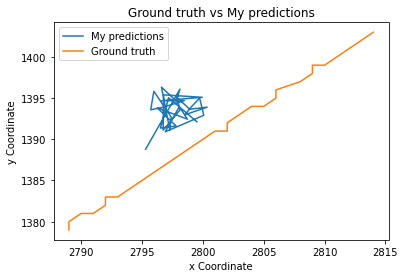

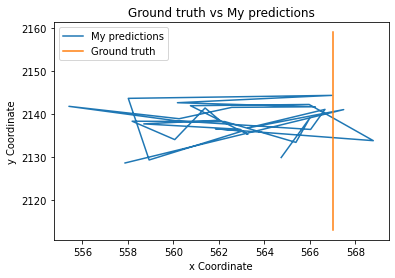

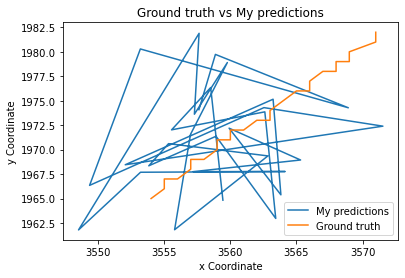

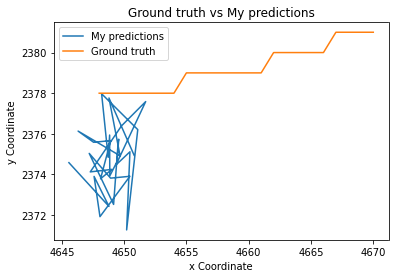

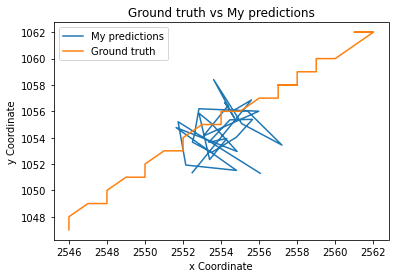

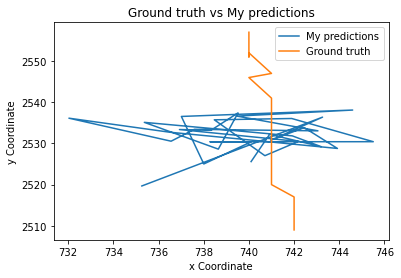

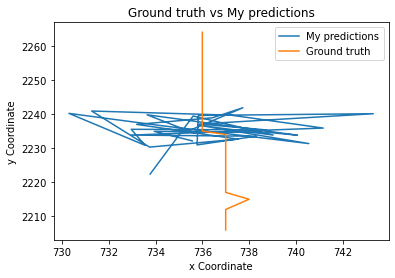

In [8]:
import matplotlib.pyplot as plt

with torch.no_grad():
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out, track_ids, agent_ids, car_mask = sample_batch

        x = torch.flatten(inp, start_dim=2)

        if cuda_status:
            model = model.cuda()
            x = x.cuda()
        else:
            x = x

        y_pred = None

        # Forward pass: predict y by passing x to the model.    
        y_pred = model(x.float())
        y_pred = torch.reshape(y_pred, torch.Size([batch_sz, 60, 30, 4]))

        chosen_tests = [0,59, 28, 37, 45]
        for j in range(64):
            agent_id = agent_ids[j]
            
            vehicle_index = 0
            found = False
            while not found:
                if track_ids[j][vehicle_index][0][0] == agent_id:
                    found = True
                else:
                    vehicle_index += 1
            
            my_out = y_pred[j,vehicle_index,:,0:2]
            curr_out = out[j,vehicle_index,:,0:2]
            
            my_x = []
            my_y = []
            out_x = []
            out_y = []
            for i in range(30):
                my_x.append(my_out[i][0].item())
                my_y.append(my_out[i][1].item())
                out_x.append(curr_out[i][0].item())
                out_y.append(curr_out[i][1].item())
            plt.plot(my_x, my_y)
            #print(list(zip(my_x,my_y)))
            #print(list(zip(out_x, out_y)))
            plt.plot(out_x, out_y)
            plt.legend(['My predictions', 'Ground truth'])
            plt.xlabel('x Coordinate')
            plt.ylabel('y Coordinate') 
            plt.title('Ground truth vs My predictions')
            #break
            plt.show()
            

        break

In [ ]:
import json

with open('x_in.txt', 'w') as filehandle:
    json.dump(x_in, filehandle)
    
with open('y_in.txt', 'w') as filehandle:
    json.dump(y_in, filehandle)
    
with open('x_out.txt', 'w') as filehandle:
    json.dump(x_out, filehandle)
    
with open('y_out.txt', 'w') as filehandle:
    json.dump(y_out, filehandle)
    
with open('vel_x_in.txt', 'w') as filehandle:
    json.dump(vel_x_in, filehandle)
    
with open('vel_x_out.txt', 'w') as filehandle:
    json.dump(vel_x_out, filehandle)

# open output file for writing
with open('vel_y_in.txt', 'w') as filehandle:
    json.dump(vel_y_in, filehandle)

with open('vel_y_out.txt', 'w') as filehandle:
    json.dump(vel_y_out, filehandle)

In [ ]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=x_in, bins='auto', density=False)
plt.xlabel('x Coordinate') 
plt.title('x Input Distribution')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=y_in, bins='auto', density=False)
plt.xlabel('y Coordinate') 
plt.title('y Input Distribution')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=x_out, bins='auto', density=False)
plt.xlabel('x Coordinate') 
plt.title('x Output Distribution')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=y_out, bins='auto', density=False)
plt.xlabel('y Coordinate') 
plt.title('y Output Distribution')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

print(len(vel_x_in))
print(len(vel_y_in))
n, bins, patches = plt.hist(x=vel_x_in, bins='auto', density=False)
plt.xlabel('x Velocity') 
plt.title('x Velocity Input Distribution')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

axes = plt.gca()
axes.set_xlim([-180,280])
#axes.set_ylim([0,17463200])

bins = []

for i in range(-180,275,20):
    bins.append(i)

#print(len(vel_y_in))
n, bins, patches = plt.hist(x=vel_y_in, bins=bins, density=False)
plt.xlabel('y Velocity') 
plt.title('y Velocity Input Distribution')
#plt.xticks(range(min(vel_y_in), max(vel_y_in)+1))
plt.show()

In [ ]:
print(min(vel_y_in))
print(max(vel_y_in))

zero_count = 0
vals = {}
for i in range(len(vel_y_in)):
    vals[vel_y_in[i]] = 1
    #if vel_y_in[i] == 0:
    #    zero_count += 1

print(len(vals.keys()))

In [ ]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=vel_x_out, bins='auto', density=False)
plt.xlabel('x Velocity') 
plt.title('x Velocity Output Distribution')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

bins = []
for i in range(-190, 200, 20):
    bins.append(i)

n, bins, patches = plt.hist(x=vel_y_out, bins=bins, density=False)
plt.xlabel('y Velocity') 
plt.title('y Velocity Output Distribution')
plt.show()

In [ ]:
print(min(vel_y_out))
print(max(vel_y_out))